In [46]:
from skimage.io import imread
import os
import pandas
import matplotlib.pyplot as plt
from scipy.signal import tukey
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [30]:
window = tukey(256, alpha=1)
window = np.outer(window, window)

def one_over_eta(rs, fs, R):
    return ((np.pi*R**2) / (np.sum(fs[rs<=R]))) * fs[rs==R]

def petrosian_radius(rs, fs):
    r_candidates = np.array([one_over_eta(rs, fs, R) for R in rs])
    return rs[np.square(r_candidates-0.2).argmin()]

def petrosian_flux(rs, fs, R_p):
    return np.sum(fs[rs<=2*R_p])

def R_x(rs, fs, x):
    x /= 100
    sum_ratio = np.cumsum(fs)/np.sum(fs)
    return rs[np.square(sum_ratio-x).argmin()]

def petrosian_Re(R_50, R_90):
    P_3 = 8e-6
    P_4 = 8.47
    return R_50 / (1 - P_3*(R_90/R_50)**P_4)

xs, ys = np.meshgrid(np.arange(128), np.arange(128))

def R_50(image):
    im = np.copy(image)
#     cy, cx = np.unravel_index(np.argmax(image), image.shape)
    cx, cy = 128, 128
    xs, ys = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]))
    rs = np.sqrt(np.square(xs-cx)+np.square(ys-cy))
    rs = rs.flatten()
    sorted_rs = np.argsort(rs)
    im *= window
    fs = im.ravel()
    rs = rs[sorted_rs]
    fs = fs[sorted_rs]
    return R_x(rs, fs, 50)

def rgb_to_gray(images):
    return np.mean(images, axis=3, keepdims=True)

In [53]:
df = pd.read_csv(os.getenv("project") + "/data/zoo2MainSpecz.csv")
datapath = os.getenv("CENSAI_PATH") + "/data/zoo2_1000_100as/"
images = []
objid = []
i = 0
for jpg in os.listdir(datapath):
    objid.append(jpg[:-4])
    images.append(imread(datapath + jpg))
    if i == 1000:
        break
    i += 1
images = rgb_to_gray(np.stack(images, axis=0))
df = df[df["dr7objid"].isin(list(map(int, objid)))]

ERROR! Session/line number was not unique in database. History logging moved to new session 762


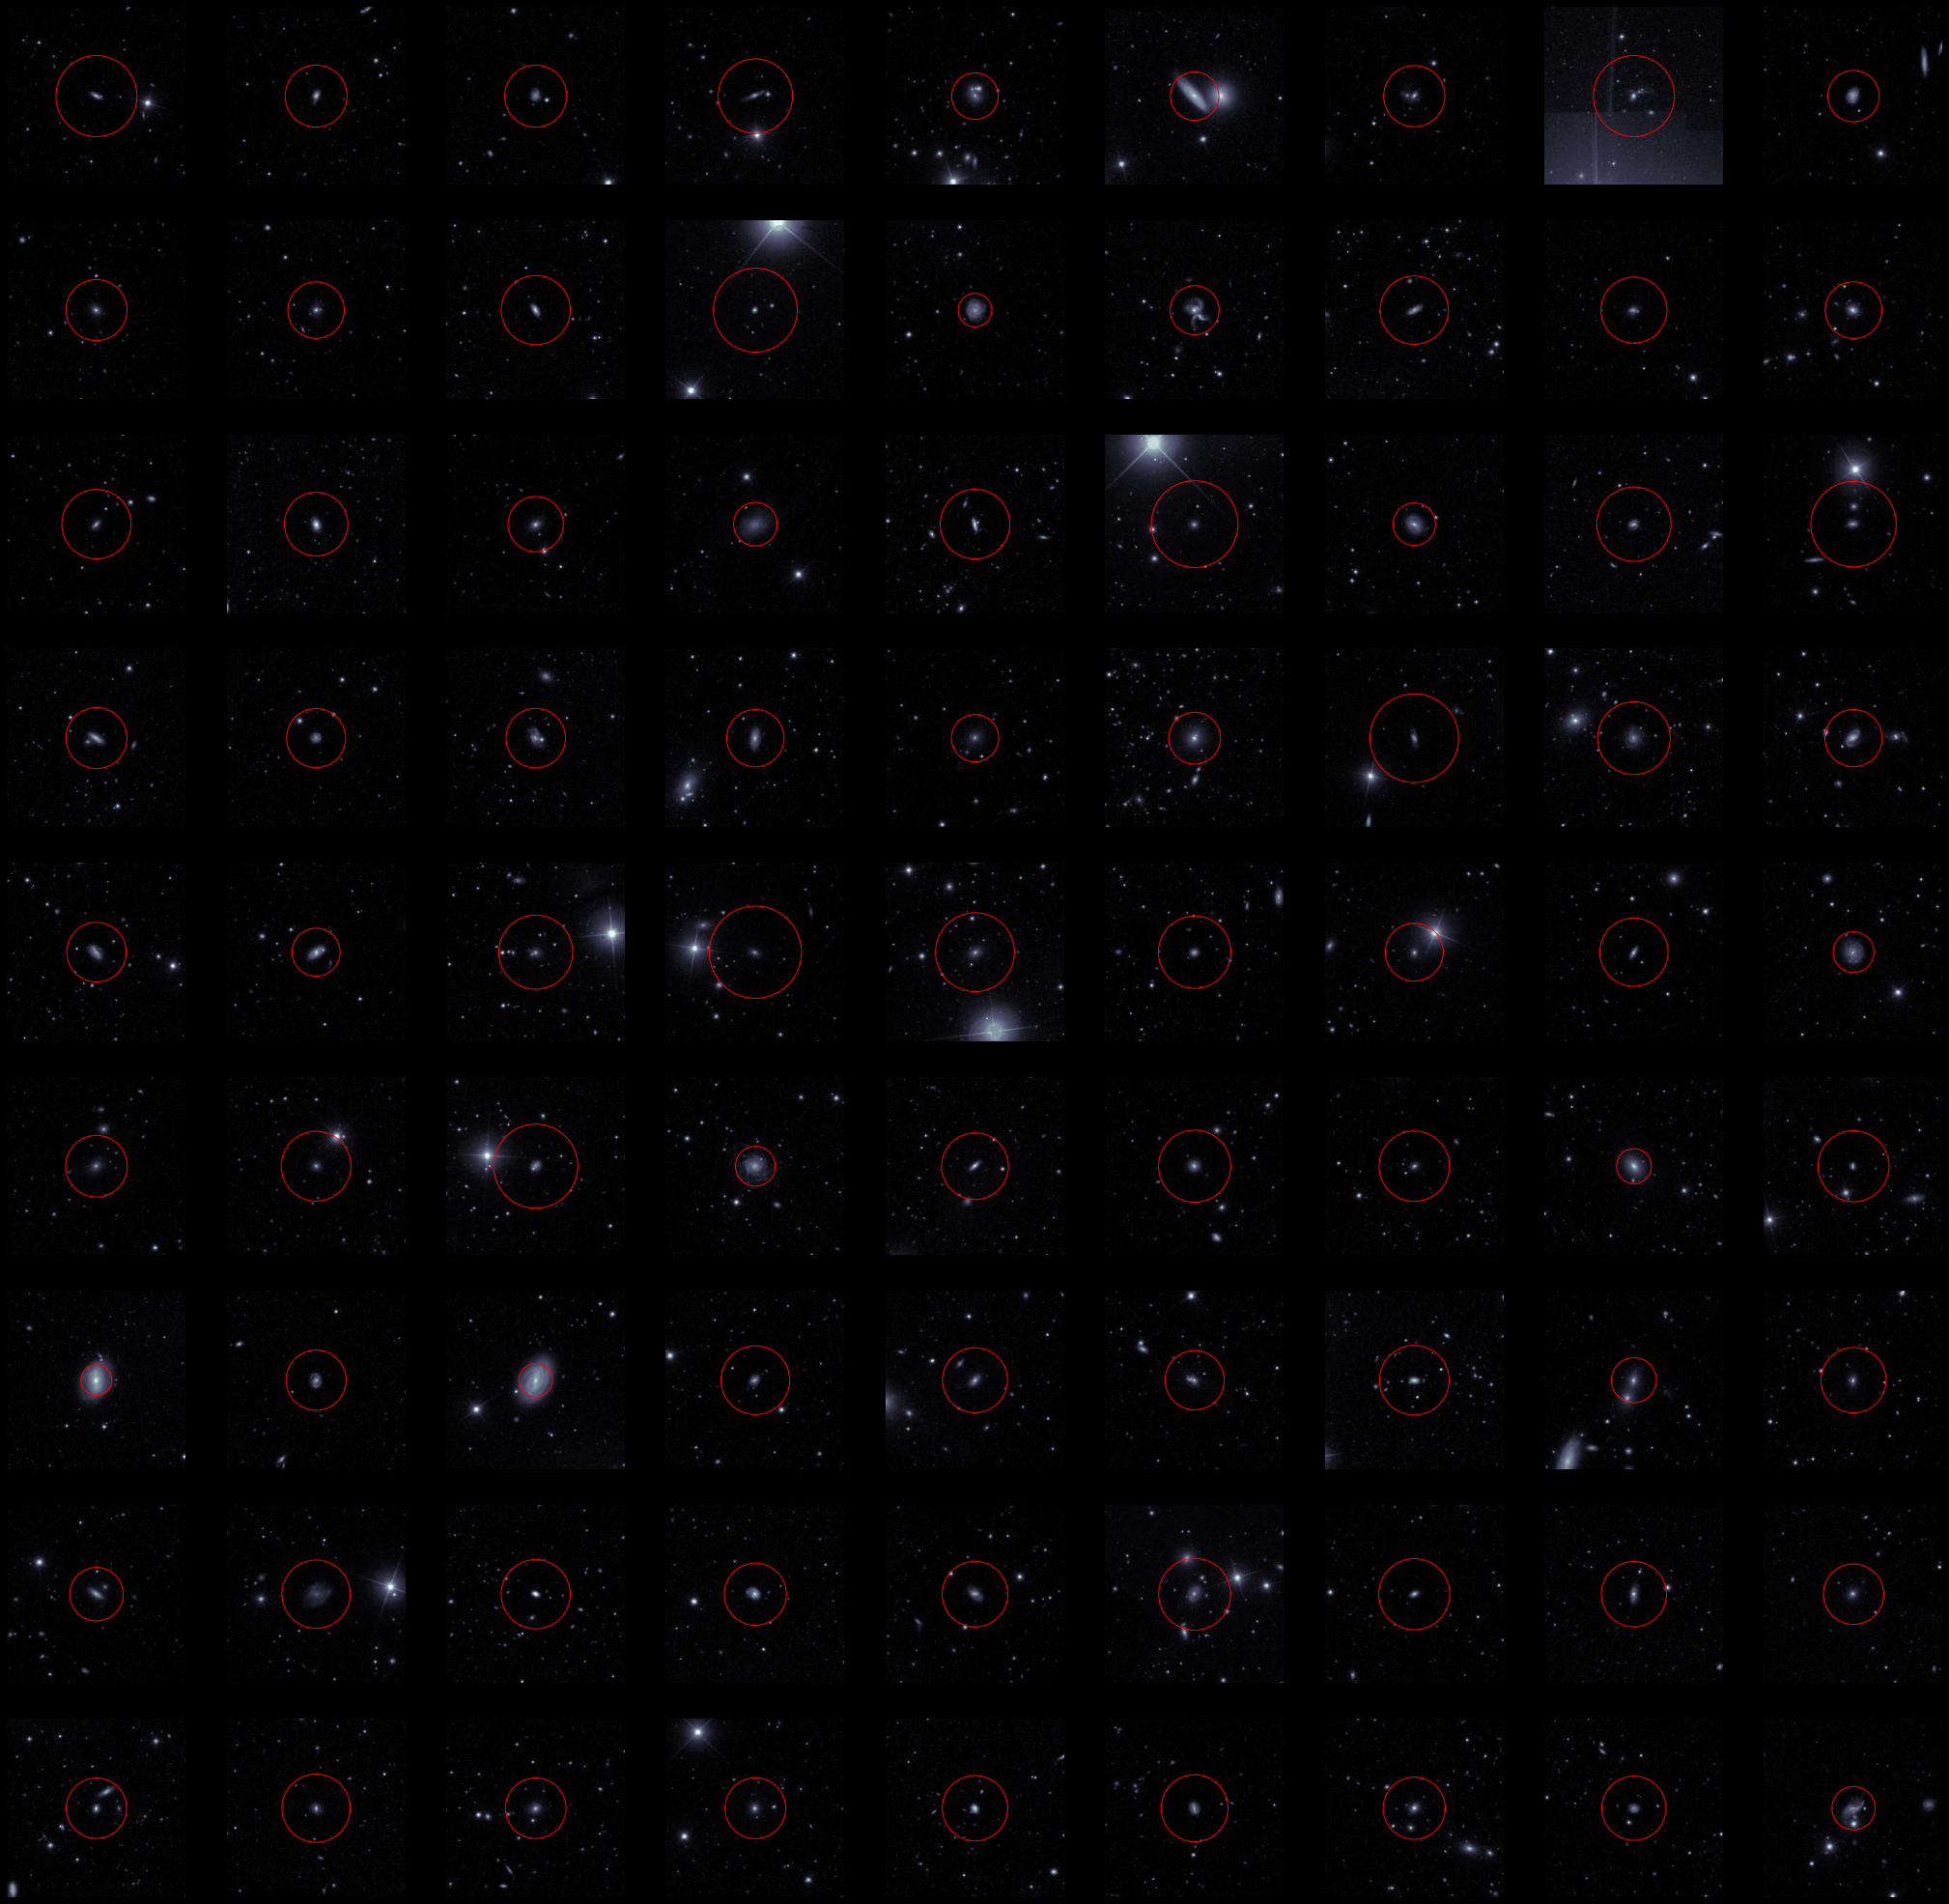

In [33]:
plt.style.use("dark_background")
fig, axs = plt.subplots(9, 9, figsize=(36, 36))
start = 100
for i in range(9):
    for j in range(9):
        k = i * 9 + j + start
        im = images[k, ..., 0]
        r_50 = R_50(im)
        cy, cx = 128, 128
        make_cir = lambda r,c: plt.Circle((cx, cy), r, color=c, fill=False)
        cir_R_50 = make_cir(r_50, 'r')
        axs[i, j].add_artist(cir_R_50)
        axs[i, j].imshow(im, cmap="bone")
        axs[i, j].axis("off")

In [54]:
df[[col for col in df if col.startswith('t01')]]

,t01_smooth_or_features_a01_smooth_count,t01_smooth_or_features_a01_smooth_weight,t01_smooth_or_features_a01_smooth_fraction,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a01_smooth_flag,t01_smooth_or_features_a02_features_or_disk_count,t01_smooth_or_features_a02_features_or_disk_weight,t01_smooth_or_features_a02_features_or_disk_fraction,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a02_features_or_disk_flag,t01_smooth_or_features_a03_star_or_artifact_count,t01_smooth_or_features_a03_star_or_artifact_weight,t01_smooth_or_features_a03_star_or_artifact_fraction,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_debiased,t01_smooth_or_features_a03_star_or_artifact_flag
18,18,18.000,0.391,0.399,0.600545,0,27,27.0,0.587,0.599,0.599000,0,1,0.074,0.022,0.002,0.002000,0
24,2,2.000,0.039,0.040,0.040000,0,48,48.0,0.941,0.958,0.958000,1,1,0.082,0.020,0.002,0.002000,0
101,5,5.000,0.094,0.094,0.094000,0,48,48.0,0.906,0.906,0.906000,1,0,0.000,0.000,0.000,0.000000,0
147,0,0.000,0.000,0.000,0.000000,0,44,44.0,1.000,1.000,1.000000,1,0,0.000,0.000,0.000,0.000000,0
173,6,5.377,0.130,0.126,0.126000,0,36,36.0,0.783,0.844,0.844000,1,4,1.288,0.087,0.030,0.030000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114267,46,46.000,0.821,0.863,0.457016,0,7,7.0,0.125,0.131,0.486673,0,3,0.291,0.054,0.005,0.004433,0
114354,32,32.000,0.744,0.744,0.330528,0,8,8.0,0.186,0.186,0.659498,0,3,3.000,0.070,0.070,0.044242,0
114394,25,25.000,0.568,0.578,0.246839,0,15,15.0,0.341,0.347,0.539108,0,4,3.282,0.091,0.076,0.052704,0
114511,39,38.170,0.907,0.921,0.660840,0,3,3.0,0.070,0.072,0.192908,0,1,0.260,0.023,0.006,0.005958,0


<AxesSubplot:>

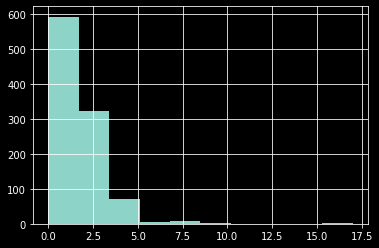

In [55]:
df["t01_smooth_or_features_a03_star_or_artifact_count"].hist()